In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
import string 

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Importing anxiety data
df_anx = pd.read_csv('../../data/original/anxiety_submissions_.csv')
df_anx = df_anx[['author', 'link_flair_text', 'num_comments', 'subreddit', 'selftext', 'title', 'created_utc']]
df_anx.head()

,author,link_flair_text,num_comments,subreddit,selftext,title,created_utc
0,JackW357,DAE Questions,9,Anxiety,NaN,Anyone else scared of dying and scared of when...,1606687976
1,belladoll1021,Health,1,Anxiety,Can a tight throat and gagging feeling be anxi...,Tight throat,1606687615
2,ashwinderegg,Advice Needed,3,Anxiety,Does anyone else feel like they can no longer ...,Anxiety overriding my intuition.,1606687588
3,ashwinderegg,Advice Needed,7,Anxiety,Does anyone else feel like they can no longer ...,Anxiety overriding my intuition.,1606687588
4,lachapoxxx,Advice Needed,1,Anxiety,my anxiety has been going crazy this past week...,hey friends! i need some advice,1606687488


In [3]:
# Importing anxiety data
df_wri = pd.read_csv('./writing_submissions.csv')
df_wri = df_wri[['author', 'link_flair_text', 'num_comments', 'subreddit','selftext', 'title', 'created_utc']]
df_wri.tail()

,author,link_flair_text,num_comments,subreddit,selftext,title,created_utc
2995,BikergirlRider120,Advice,2,writing,So I got a idea for a story about a young woma...,An idea for a story,1631761561
2996,throwaway3352617,Advice,4,writing,A large part of the character arc I'm writing ...,Differentiating between character strengths: D...,1631761310
2997,Midget_Cowboy,NaN,30,writing,"So, to jump right into it, what, in your opini...","Proper Time to Introduce the ""Big Incident""",1631761085
2998,throwaway5820175,Advice,5,writing,I'm wanting to write a book series based stron...,Possible copyright issues?,1631759726
2999,Longjumping-Celery54,Other,1,writing,She wakes up in Atlanta\n\nIn the world of The...,"A poem I wrote called ""Another World""",1604277033


In [4]:
df = df_anx.append(df_wri, ignore_index=True)

In [5]:
df.shape

(6000, 7)

In [6]:
df['selftext'].fillna('', inplace = True)

In [7]:
df['text'] = df['title'] + ' ' + df['selftext']
df['text'] = [str(x).lower() for x in df["text"]]
df['text'] = df['text'].replace('\n', " ")
df['text'] = [str(x).replace('\n\n',' ') for x in df["text"]]
df['text'] = [str(x).replace('&amp','') for x in df["text"]]
df['text'] = [str(x).replace(';#x200B;','') for x in df["text"]]

In [8]:
df = df.drop(columns = ['title', 'selftext'])

In [9]:
df['text'].isnull().sum()

0

In [10]:
df.drop_duplicates(subset=['text', 'subreddit'], inplace = True)

In [11]:
df['subreddit'].apply(lambda x: 1 if x == 'Anxiety' else 0)

0       1
1       1
2       1
4       1
5       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: subreddit, Length: 5941, dtype: int64

In [12]:
# find specific deleted texts
df[df['text']=='[deleted]']

,author,link_flair_text,num_comments,subreddit,created_utc,text


In [13]:
df['text'][0]

'anyone else scared of dying and scared of when you die will anxiety carry on???? '

In [14]:
df.apply(lambda col: col.drop_duplicates().reset_index(drop=True))

,author,link_flair_text,num_comments,subreddit,created_utc,text
0,JackW357,DAE Questions,9.0,Anxiety,1.606688e+09,anyone else scared of dying and scared of when...
1,belladoll1021,Health,1.0,writing,1.606688e+09,tight throat can a tight throat and gagging fe...
2,ashwinderegg,Advice Needed,3.0,NaN,1.606688e+09,anxiety overriding my intuition. does anyone e...
3,lachapoxxx,Therapy,0.0,NaN,1.606687e+09,hey friends! i need some advice my anxiety has...
4,hayhay1105,NaN,2.0,NaN,1.606687e+09,oh boy do you ever get physically sick thinkin...
...,...,...,...,...,...,...
5935,NaN,NaN,NaN,NaN,NaN,an idea for a story so i got a idea for a stor...
5936,NaN,NaN,NaN,NaN,NaN,differentiating between character strengths: d...
5937,NaN,NaN,NaN,NaN,NaN,"proper time to introduce the ""big incident"" so..."
5938,NaN,NaN,NaN,NaN,NaN,possible copyright issues? i'm wanting to writ...


### Tokenizing and Lemmatizing

In [15]:
# sentence tokenizer
df['sent_tokenized'] = df["text"].apply(nltk.sent_tokenize)

In [16]:
def check_find_punctuations(text):
    result = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', text)
    string = "".join(result)
    return list(string)

df['punctuation_used'] = df['text'].apply(lambda x : check_find_punctuations(x))

df.head(2)

,author,link_flair_text,num_comments,subreddit,created_utc,text,sent_tokenized,punctuation_used
0,JackW357,DAE Questions,9,Anxiety,1606687976,anyone else scared of dying and scared of when...,[anyone else scared of dying and scared of whe...,"[?, ?, ?, ?]"
1,belladoll1021,Health,1,Anxiety,1606687615,tight throat can a tight throat and gagging fe...,[tight throat can a tight throat and gagging f...,[?]


In [17]:
sentence = df['text'][0]
sentence

'anyone else scared of dying and scared of when you die will anxiety carry on???? '

### For same consecutive punctuation

In [18]:
def repeated_punctuations(text):
    pattern_any_punctuation = re.compile('([-/\\\\()?!"+,&\'...]{2,})') # min. 2 or more
    list_of_punct = []
    match = pattern_any_punctuation.search(str(text))
    if match:
        match = match.group(0)
        list_of_punct.append(match)
        return list_of_punct
    else:
        return 0

In [19]:
df['repeated_punct'] = df['text'].apply(lambda x : repeated_punctuations(x))

In [20]:
df['punctuation_count'] = df['punctuation_used'].apply(len)

In [21]:
df['text'][5995]

"an idea for a story so i got a idea for a story about a young woman named victoria (might change name). victoria has powers who lives in a world where people have powers, some criminals and some villains. she's hurt people, killed even but not kids. she's done bad things, yet it took her 5yrs to realize that she was under control of a telepath. her demon. a monster. the man in the suit as she calls him. she's kept her distance from him. until she can't anymore when the man in the suit finds a way to get at her in ways that she may and may not expect....  i would like to name the story after the victoria. yet, at the same time, i'd like to name it different names: desire. temptation. resist. fight. i haven't figured out the story, the plot and characters since it's something that i just came up with."

In [22]:
df['repeated_punct']

0       [????]
1            0
2            0
4            0
5         [??]
         ...  
5995      [).]
5996     ['),]
5997      [".]
5998         0
5999     [...]
Name: repeated_punct, Length: 5941, dtype: object

### Let's take a look at punctuation

In [23]:
counts = df.groupby(by ='subreddit').agg('describe')[['punctuation_count']]
counts

punctuation_count                                                   
                      count       mean        std  min  25%   50%   75%    max
subreddit                                                                     
Anxiety              2993.0  20.961577  28.230541  0.0  6.0  14.0  26.0  453.0
writing              2948.0  19.470488  45.522367  0.0  3.0   8.0  20.0  999.0

In [24]:
anx = df[df['subreddit'] == 'Anxiety']
writ = df[df['subreddit'] == 'writing']

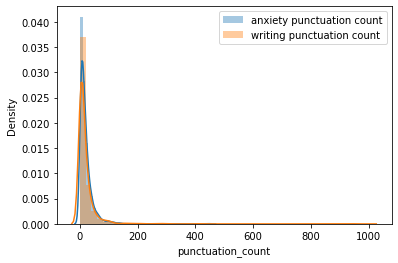

In [25]:
sns.distplot(anx.punctuation_count, norm_hist = True, label = "anxiety punctuation count")
sns.distplot(writ.punctuation_count, norm_hist = True, label = 'writing punctuation count')
plt.legend();

In [26]:
df.head()

,author,link_flair_text,num_comments,subreddit,created_utc,text,sent_tokenized,punctuation_used,repeated_punct,punctuation_count
0,JackW357,DAE Questions,9,Anxiety,1606687976,anyone else scared of dying and scared of when...,[anyone else scared of dying and scared of whe...,"[?, ?, ?, ?]",[????],4
1,belladoll1021,Health,1,Anxiety,1606687615,tight throat can a tight throat and gagging fe...,[tight throat can a tight throat and gagging f...,[?],0,1
2,ashwinderegg,Advice Needed,3,Anxiety,1606687588,anxiety overriding my intuition. does anyone e...,"[anxiety overriding my intuition., does anyone...","[., ?, ., ., ., ., ., ., ,, ', ., ., ?]",0,13
4,lachapoxxx,Advice Needed,1,Anxiety,1606687488,hey friends! i need some advice my anxiety has...,"[hey friends!, i need some advice my anxiety h...","[!, ,, ,, ., ?]",0,5
5,hayhay1105,Therapy,0,Anxiety,1606687339,oh boy do you ever get physically sick thinkin...,[oh boy do you ever get physically sick thinki...,"[', ?, ?]",[??],3


In [27]:
pd.option_context('display.max_colwidth', -1)
df['repeated_punct'].head(1)

0    [????]
Name: repeated_punct, dtype: object

In [28]:
# Defining our Baseline with post counts, which some duplicates were dropped
df['subreddit'].value_counts(normalize = True)

Anxiety    0.503787
writing    0.496213
Name: subreddit, dtype: float64

In [29]:
# Extending my list of stop words
stop_words = stopwords.words("english")
new_stop_words = ['like', 'just', 'don', 've', 'know', 'time', 'really', 
                'want', 'people', 'going', 'think', 'make', 'day', 
                'https', 'com', 'much', 'something', 'would', 'go',
               'even', 'things', 'also', 'got', 'www', 'could', 'take', 'anxiety', 'writer']
stop_words.extend(new_stop_words)

In [30]:
# Instantiate tokenizer.
tokenizer = RegexpTokenizer('\s+', gaps=True)

In [31]:
# Run tokenizer.
df['tokens'] = df["text"].apply(tokenizer.tokenize)

In [32]:
# Instantiate lemmatizer. 
lemmatizer = WordNetLemmatizer()

In [33]:
# Lemmatize tokens.
df['tokens_lem'] = [lemmatizer.lemmatize(str(i)) for i in df['tokens']]
df['tokens_lem']

0       ['anyone', 'else', 'scared', 'of', 'dying', 'a...
1       ['tight', 'throat', 'can', 'a', 'tight', 'thro...
2       ['anxiety', 'overriding', 'my', 'intuition.', ...
4       ['hey', 'friends!', 'i', 'need', 'some', 'advi...
5       ['oh', 'boy', 'do', 'you', 'ever', 'get', 'phy...
                              ...                        
5995    ['an', 'idea', 'for', 'a', 'story', 'so', 'i',...
5996    ['differentiating', 'between', 'character', 's...
5997    ['proper', 'time', 'to', 'introduce', 'the', '...
5998    ['possible', 'copyright', 'issues?', "i'm", 'w...
5999    ['a', 'poem', 'i', 'wrote', 'called', '"anothe...
Name: tokens_lem, Length: 5941, dtype: object

In [34]:
# Remove stopwords from "tokens."
df['no_stop_words'] = [word for word in df['tokens_lem'] if word not in stopwords.words('english')]

In [35]:
df['subreddit'] = df['subreddit'].map({'Anxiety': 1, 'writing':0})

### Drop duplicates

In [36]:
# Count the number of headlines in scored_news (store as integer)
num_before = df.text.count()
# Drop duplicates based on ticker and headline
df_clean = df.drop_duplicates(subset=['text', 'subreddit'])
# Count number of posts after dropping duplicates (store as integer)
num_after = df_clean.text.count()
# Print before and after numbers to get an idea of how we did
f"Before we had {num_before} texts, now we have {num_after}"

'Before we had 5941 texts, now we have 5941'

### Adding punctuation weights to sentiment analysis

In [46]:
df.head(20)

,negative,neutral,positive
0,0.529,0.471,0.000
1,0.152,0.714,0.134
2,0.124,0.704,0.171
4,0.146,0.662,0.192
5,0.129,0.803,0.068
6,0.239,0.699,0.061
7,0.183,0.765,0.052
8,0.063,0.781,0.156
9,0.089,0.874,0.037
10,0.046,0.866,0.088


In [38]:
# New words and values
new_words = {
'???': -1,
'...': -0.3,
'?!?!': -1.5,
'!!!': -1
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

In [39]:
columns = ['subreddit', 'text', 'created_utc']
scores = [vader.polarity_scores(str(word)) for word in df.text]
scored_df = pd.DataFrame(scores)
df = df.join(scored_df)

In [45]:
df.head(20)

,negative,neutral,positive
0,0.529,0.471,0.000
1,0.152,0.714,0.134
2,0.124,0.704,0.171
4,0.146,0.662,0.192
5,0.129,0.803,0.068
6,0.239,0.699,0.061
7,0.183,0.765,0.052
8,0.063,0.781,0.156
9,0.089,0.874,0.037
10,0.046,0.866,0.088


In [41]:
# Making a date column from created utc, unstacking
df['date'] = pd.to_datetime(df['created_utc'], unit = 's').dt.date
df_date = df.groupby(['date', 'subreddit']).mean()
df_unstacked = df_date.unstack('subreddit')
df_cross = df_unstacked.xs("compound", axis="columns")

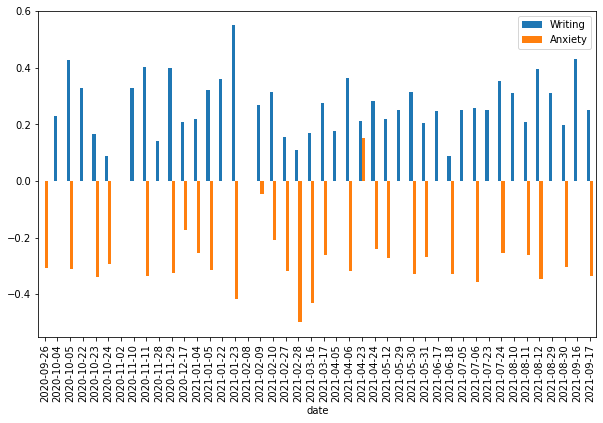

In [42]:
# Group by date and subreddit columns from body and calculate the mean
mean_c = df.groupby(['date', 'subreddit']).mean()
# Unstack the column subreddit
mean_c = mean_c.unstack('subreddit')
# Get the cross-section of compound sentitivity analysis in the 'columns' axis
mean_c = mean_c.xs("compound", axis="columns")
# Plot a bar chart with pandas
mean_c.plot.bar(figsize = (10, 6))
plt.legend(["Writing", "Anxiety"])
plt.savefig('sentiment_small.png');

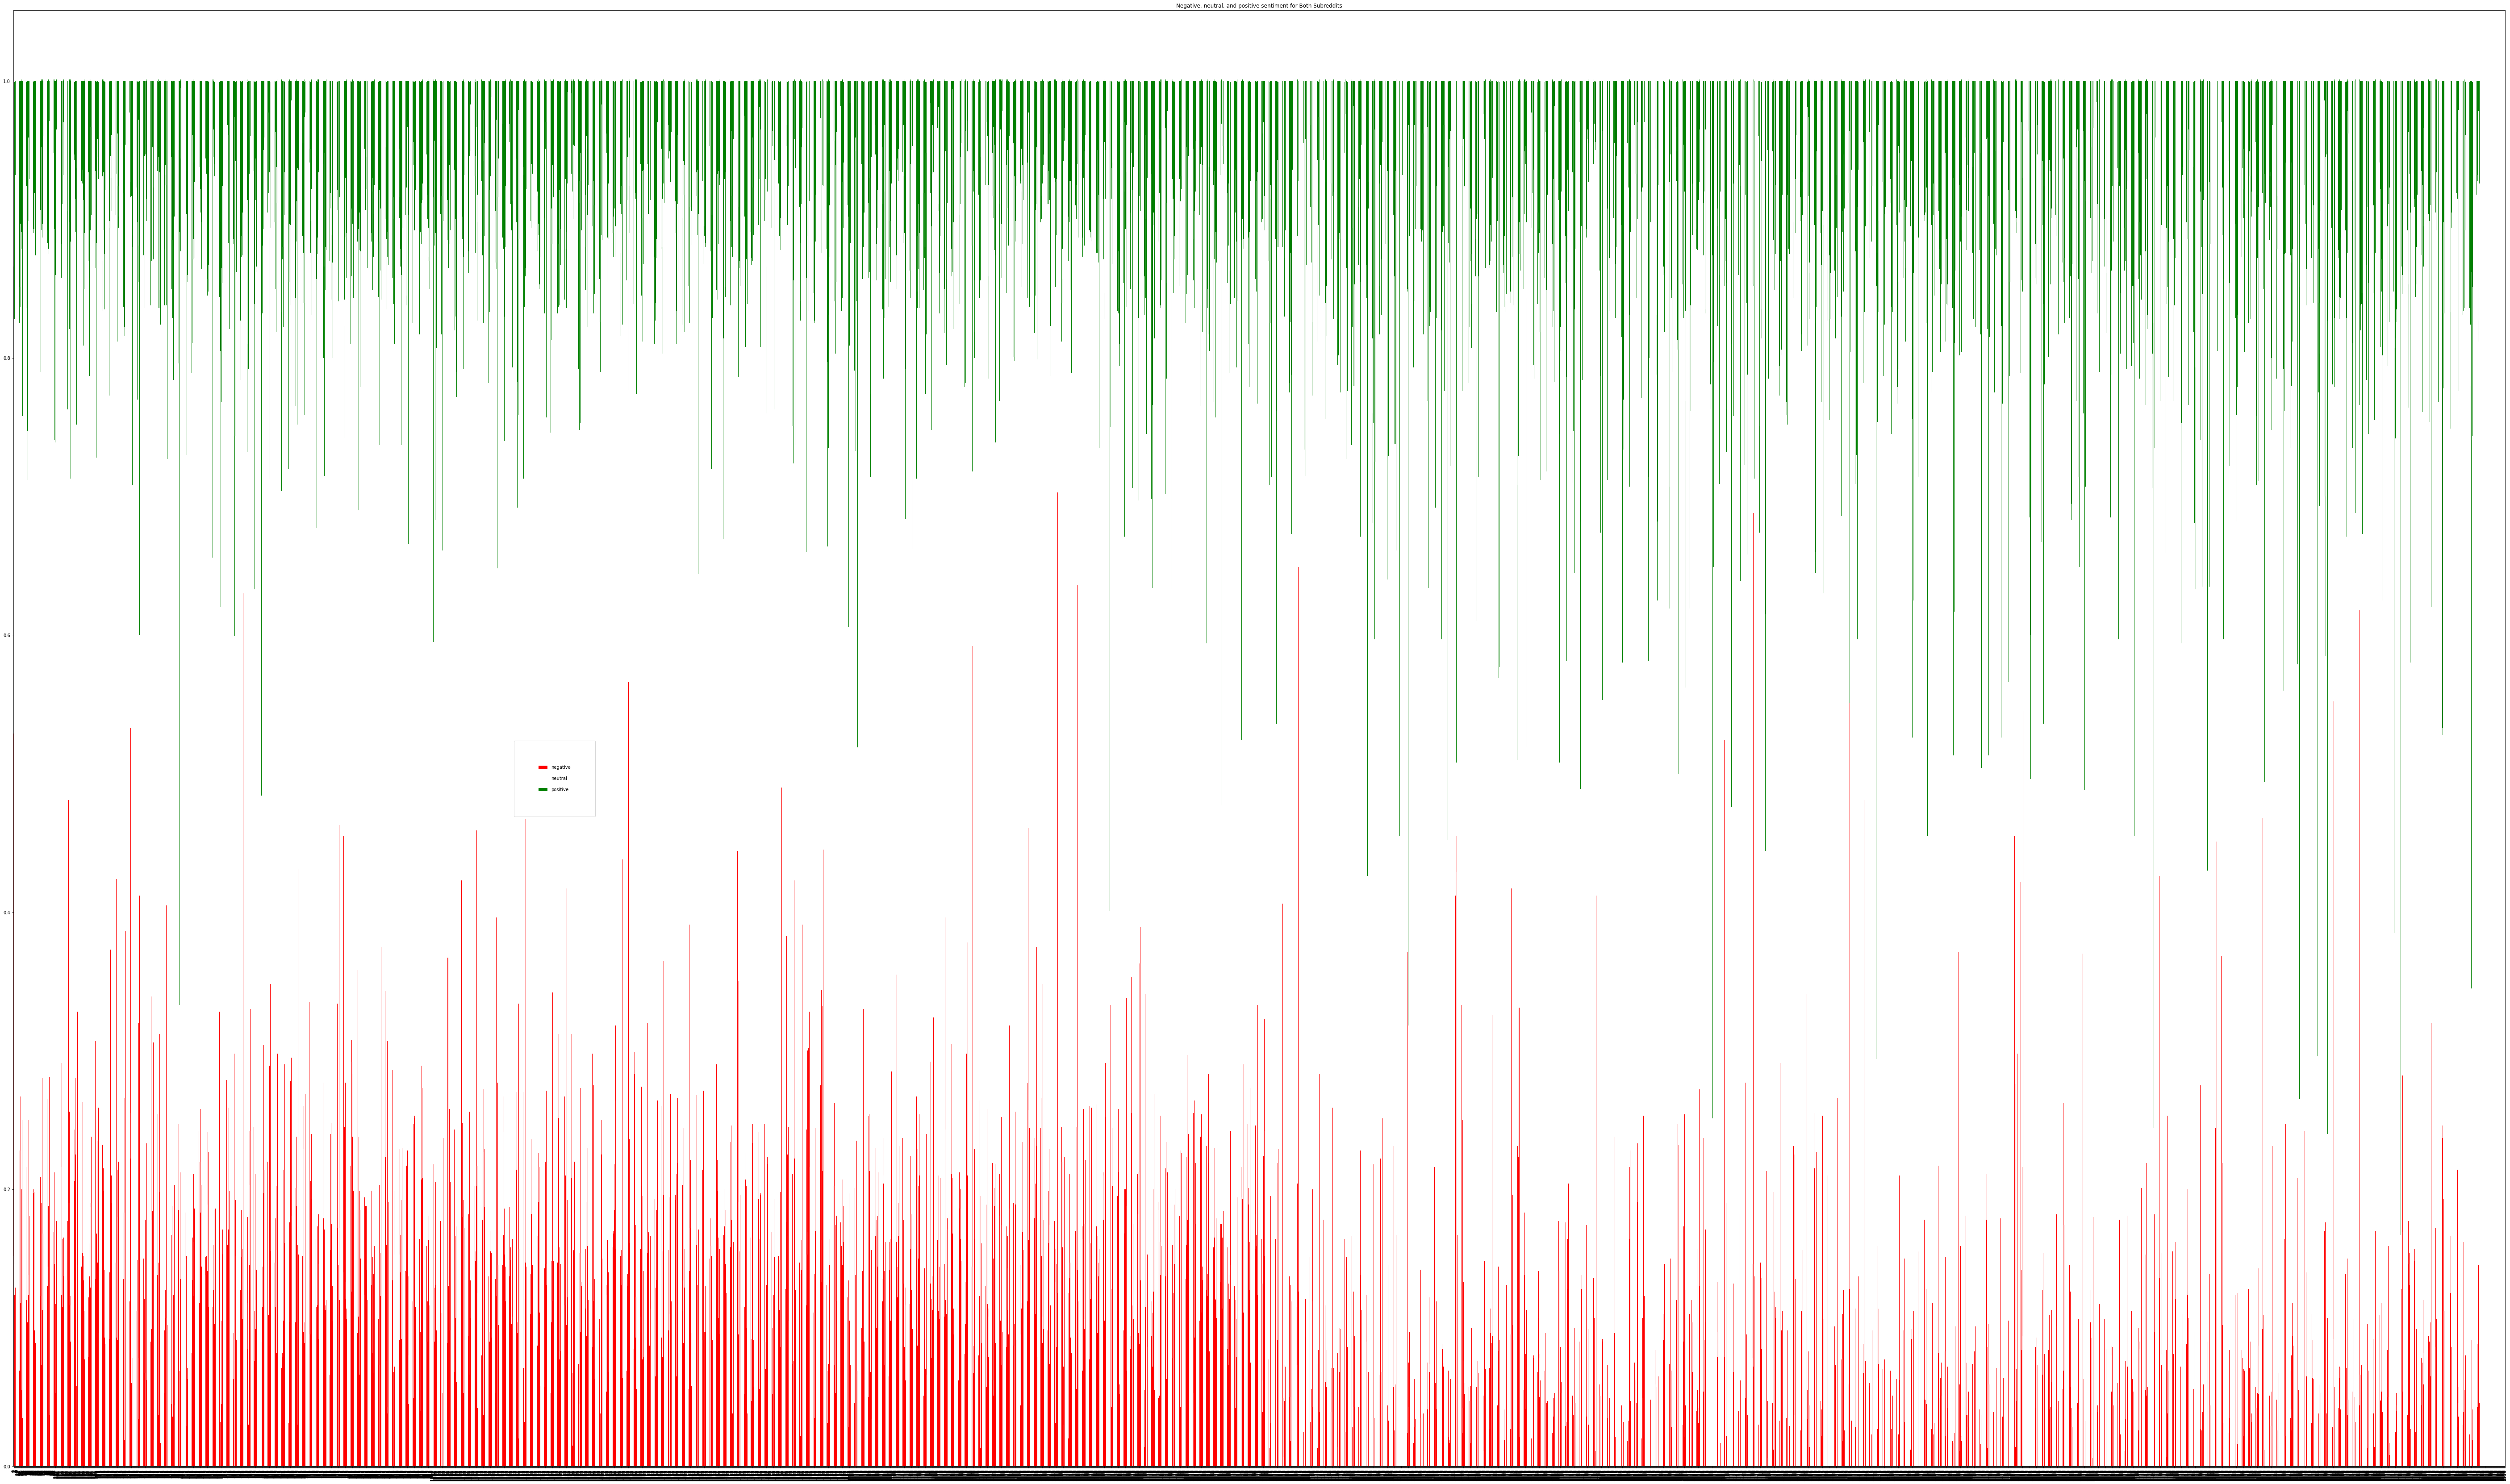

In [43]:
TITLE = "Negative, neutral, and positive sentiment for Both Subreddits"
COLORS = ["red","white", "green"]
# Drop the columns that aren't useful for the plot
df = df[['neg', 'neu', 'pos']]
# Change the column names to 'negative', 'positive', and 'neutral'
df.columns = ['negative', 'neutral', 'positive']
# Plot a stacked bar chart
df.plot.bar(stacked = True, figsize=(100, 60),
title = TITLE, color = COLORS).legend(bbox_to_anchor=(0.2, 0.5), borderpad=5.5, labelspacing=1.5)
plt.savefig('Punctuation_negative_neutral_positive.png');